# Camera intrinsic calibration

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# imports
%matplotlib inline
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

In [3]:
import sys
code_dir = '/camp/lab/znamenskiyp/home/users/blota/code/Calibrations/ScreenCalibration/Python'
if code_dir not in sys.path:
    sys.path.append(code_dir)
import camera_calibration as camcal

In [4]:
# find the data
project = 'blota_onix_pilote'
data_root = Path('/camp/lab/znamenskiyp/data/instruments/raw_data/projects/')
data_root = data_root / project / 'calibration' / 'camera_intrinsics'
save_root = Path('/camp/lab/znamenskiyp/home/shared/projects') / project

## Detect checkerboards

27 images to analyse
Found corners for 25 images
    computing
    That took 1.34 seconds. Saving
33 images to analyse
Found corners for 32 images
    computing
    That took 2.76 seconds. Saving
35 images to analyse
Found corners for 35 images
    computing
    That took 3.50 seconds. Saving


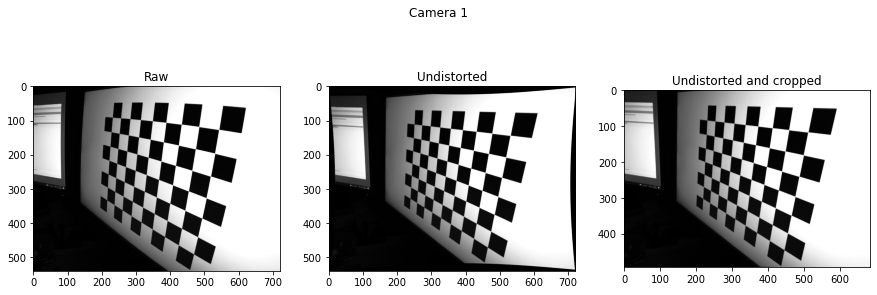

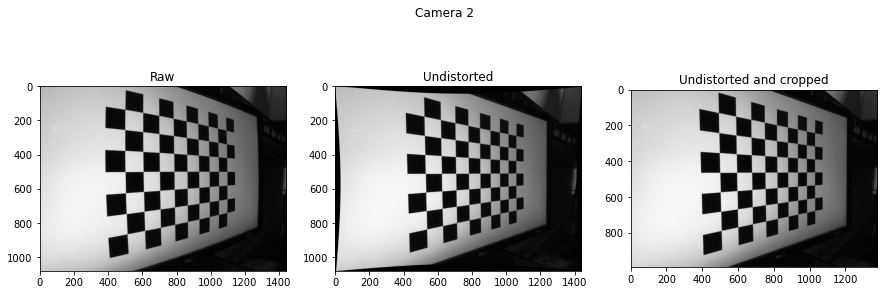

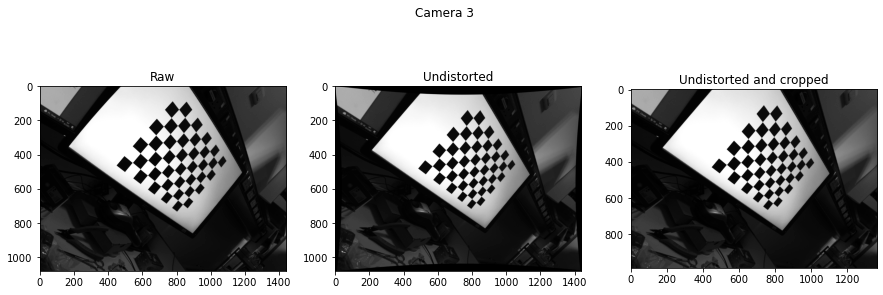

In [63]:
prefix = 'cam'
image_format = 'png'

REDO = True
for icam in range(1,4):
    
    # Find the checkboard in all pictures
    savefile = save_root  / ('corner_pts_cam%d.npz' %icam)
    folder = data_root / ('cam%d'%icam)

    if savefile.exists() and not REDO:
        data = np.load(savefile)
        objpoints = data['objpoints']
        imgpoints = data['imgpoints']
    else:
        [objpoints, imgpoints] = camcal.calibrate(dirpath=str(folder), 
                                                  prefix=prefix, 
                                                  image_format=image_format,
                                                  square_size=33.5, 
                                                  width=9, 
                                                  height=7,
                                                  display=False,
                                                  verbose=1,
                                                  savepts=str(savefile),
                                                  do_calibrate=False
                                                 )
    # Now calibrate
    savefile = save_root  / ('cam%d_intrinsic_calibration.npz' %icam)
    if savefile.exists() and not REDO:
        data = np.load(savefile)
        ret=data['ret']
        mtx=data['mtx']
        dist=data['dist']
        rvecs=data['rvecs']
        tvecs=data['tvecs']
    else:
        print('    computing')
        e1 = cv2.getTickCount()
        images = folder.glob(prefix + '*.' + image_format)
        img = cv2.imread(str(next(images)))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        h, w = gray.shape
        out = cv2.calibrateCamera(objpoints, imgpoints, (w,h), None, None)    
        e2 = cv2.getTickCount()
        t = (e2 - e1) / cv2.getTickFrequency()
        print('    That took %.2f seconds. Saving' % t)
        ret, mtx, dist, rvecs, tvecs = out
        np.savez(str(savefile), ret=ret, mtx=mtx, dist=dist, rvecs=rvecs, tvecs=tvecs)
        
        # save the output
        camcal.save_coefficients(mtx, dist, ret, path=str(save_root / ('camera_%d_calibration.xml'%icam)))
        np.savez(save_root/('camera_%d_calibration.npz'%icam), mtx=mtx, dist=dist, ret=ret)
        
        # plot example
        
        # get a newcamera matrix that resize the image to keep black pixels
        newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
        # undistort example frame
        dst = cv2.undistort(gray, mtx, dist, None, newcameramtx)
        # crop the image
        x, y, w, h = roi
        dst_crop = dst[y:y+h, x:x+w]

        fig = plt.figure(figsize=(15,5))
        ax = fig.add_subplot(1,3,1)
        ax.set_title('Raw')
        ax.imshow(gray, cmap='Greys_r')
        ax = fig.add_subplot(1,3,2)
        ax.imshow(dst, cmap='Greys_r')
        ax.set_title('Undistorted')
        ax = fig.add_subplot(1,3,3)
        ax.imshow(dst_crop, cmap='Greys_r')
        ax.set_title('Undistorted and cropped')
        fig.suptitle('Camera %d'%icam)
        fig.savefig(save_root / ('example_undistortion_cam%d.png'%icam))